In [1]:
import numpy as np
from astropy.stats import mad_std
from scipy.stats import norm
from astropy.stats import mad_std
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#PyTorch_data = np.genfromtxt('PyTorch_OGLE-III-BLG101_30sources_no_read_noise.txt')
#pyDANDIA_data = np.genfromtxt('pyDANDIA_OGLE-III-BLG101_30sources_no_read_noise.txt')
#PyTorch_data = np.genfromtxt('PyTorchDIA_OGLE_BLG101_uncertainty_bugfix.txt')
#pyDANDIA_data = np.genfromtxt('pyDANDIA_OGLE_BLG101_uncertainty_bugfix.txt')
PyTorch_data = np.genfromtxt('PyTorchDIA_OGLE_BLG101_lossconvtest#2.txt')
pyDANDIA_data = np.genfromtxt('pyDANDIA_OGLE_BLG101_lossconvtest#2.txt')
flux_fraction = np.genfromtxt('Flux_fraction.txt')
print(PyTorch_data.shape, pyDANDIA_data.shape, flux_fraction.shape)

print(PyTorch_data[:,[4,5,6]])
print(pyDANDIA_data[:,[4,5,6]])

print(len(np.unique(PyTorch_data[:,5])))

(7414, 7) (7414, 7) (30, 2)
[[3.60933862e+02 1.00579057e+01 0.00000000e+00]
 [1.53259375e+03 1.00579057e+01 1.00000000e+00]
 [2.60451824e+02 1.00579057e+01 2.00000000e+00]
 ...
 [1.20273572e+02 1.02003504e+01 2.70000000e+01]
 [2.37231581e+02 1.02003504e+01 2.80000000e+01]
 [1.20223752e+02 1.02003504e+01 2.90000000e+01]]
[[3.60933862e+02 1.00579057e+01 0.00000000e+00]
 [1.53259375e+03 1.00579057e+01 1.00000000e+00]
 [2.60451824e+02 1.00579057e+01 2.00000000e+00]
 ...
 [1.20273572e+02 1.02003504e+01 2.70000000e+01]
 [2.37231581e+02 1.02003504e+01 2.80000000e+01]
 [1.20223752e+02 1.02003504e+01 2.90000000e+01]]
249


In [3]:
# deal with nans for now
#PyTorch_data[np.isnan(PyTorch_data) == True] = 0.

# identify nans
nans = np.where(np.isnan(PyTorch_data) == True)
rows = np.unique(nans[0])
print(rows)
#print(PyTorch_data[rows[0]], PyTorch_data[rows[1]])
#print(pyDANDIA_data[rows[0]], pyDANDIA_data[rows[1]])

pyDANDIA_data = pyDANDIA_data[~np.isnan(PyTorch_data).any(axis=1)]
PyTorch_data = PyTorch_data[~np.isnan(PyTorch_data).any(axis=1)]
print(pyDANDIA_data.shape, PyTorch_data.shape)

# good - looks like they both come from the same image, and
# are stamps 14 and 26 respectively - re run now and works fine with no tweaking...
# so not sure why it failed the first time??

[]
(7414, 7) (7414, 7)


In [4]:
'''
## load the no-longer-nan data associated with the image identified above
nln = np.genfromtxt('PyTorchDIA_OGLE_BLG101_uncertainty_bugfix_nans.txt')


# use fwhm as unique image identifier
fwhm = np.round(15.69877695, 3)
locations = np.where(np.round(PyTorch_data[:, 5], 3) == fwhm)

# check shapes match
print(PyTorch_data[locations].shape, nln.shape)

# replace
PyTorch_data[locations] = nln
'''

"\n## load the no-longer-nan data associated with the image identified above\nnln = np.genfromtxt('PyTorchDIA_OGLE_BLG101_uncertainty_bugfix_nans.txt')\n\n\n# use fwhm as unique image identifier\nfwhm = np.round(15.69877695, 3)\nlocations = np.where(np.round(PyTorch_data[:, 5], 3) == fwhm)\n\n# check shapes match\nprint(PyTorch_data[locations].shape, nln.shape)\n\n# replace\nPyTorch_data[locations] = nln\n"

In [5]:
def metrics(data, stamp_info, plot):
    
    MFBs = data[:,0]
    MFVs = data[:,1]
    Ps = data[:,2]
    norm_resids = data[:,3]
    image_SNRs = data[:,4]
    stamp_ids = data[:,6]
    ids = np.unique(stamp_ids)
    
    # get rid of variable (stamp 1)
    ids = ids[ids != 1.0]

    MPBs = []
    MPVs = []
    MedPBs = []
    MedPVs = []
    
    # image info
    ffs = []
    SNRs = []
        
    for i in ids:
        indices = np.where(stamp_ids == i)
        MFB = MFBs[indices]
        MFV = MFVs[indices]
        resids = norm_resids[indices]
        SNR = image_SNRs[indices]

        # MPB and MPV
        N_set = len(resids)
        MPB = 1./N_set * np.sum(resids)
        MPV = 1./(N_set - 1) * np.sum((resids - MPB)**2)
        MPBs.append(MPB)
        MPVs.append(MPV)
        MedPBs.append(np.median(resids))
        MedPVs.append((mad_std(resids))**2)
        
        # flux fraction
        ff = flux_fraction[:,1][np.where(i == flux_fraction[:,0])][0]
        ffs.append(ff)
        
        # median SNR of stamp
        SNRs.append(np.median(SNR))
        
        if stamp_info == True:
            print('\nStamp:', i)
            print('F_source/F_total:', ff)
            print('Median SNR:', np.median(SNR))
            print('Median P:', np.median(Ps))
            print('Median MFB:', np.median(MFB))
            print('Median MFV:', np.median(MFV))
            print('MPB:', MPB)
            print('MPV:', MPV)
            print('MedianPB:', np.median(resids))
            print('MedianPV:', (mad_std(resids))**2)

        if plot == True:
            plt.figure(figsize=(5,5))
            #plt.hist(norm_resids, bins='auto', density=True)
            plt.hist(resids, bins='auto', density=True)

            #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
            x = np.linspace(-5, 5, 100)
            plt.plot(x, norm.pdf(x, 0, 1))
            plt.xlim(-20, 20)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            plt.xlabel('Normalised residuals', fontsize=20)
            plt.ylabel('Probability', fontsize=20)
            #plt.savefig(os.path.join(path, 'NormalisedResids.png'), bbox_inches='tight', overwrite=True)
            plt.show()

    print('\nMedian P:', np.median(Ps))
    print('\nMedian MFB:', np.median(MFBs))
    print('Median MFV:', np.median(MFVs))    
    print('\nMedian MPB:', np.median(MPBs))
    print('Median MPV:', np.median(MPVs))
    print('\nMedian MedPB:', np.median(MedPBs))
    print('Median MedPV:', np.median(MedPVs))
    
    plt.figure()
    plt.scatter(MedPVs, ffs)
    plt.xlabel('MedPV')
    plt.ylabel('Flux fraction')
    plt.show()
    
    plt.figure()
    plt.scatter(MedPVs, SNRs)
    plt.xlabel('MedPV')
    plt.ylabel('Median stamp SNR')
    plt.show()
    
    print('Max SNR:', np.nanmax(SNRs))

(7414, 7) (7414, 7)
PyTorch

Median P: 1.0024792531921582

Median MFB: 0.04431480312754474
Median MFV: 1.3434810569348679

Median MPB: -0.9841028314390514
Median MPV: 7.188760260242249

Median MedPB: -0.9461108446121216
Median MedPV: 5.095314421331216


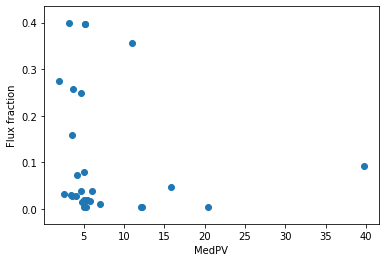

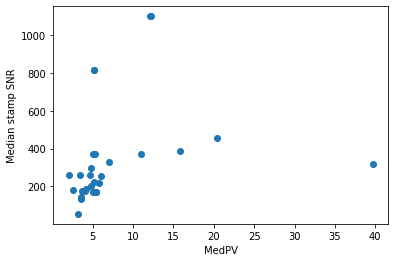

Max SNR: 1099.2532519772087

pyDANDIA

Median P: 1.0

Median MFB: 0.0012111576565091032
Median MFV: 1.3238973710543576

Median MPB: -1.0524459037271487
Median MPV: 6.49597285419594

Median MedPB: -0.9616406559944153
Median MedPV: 4.643230037075359


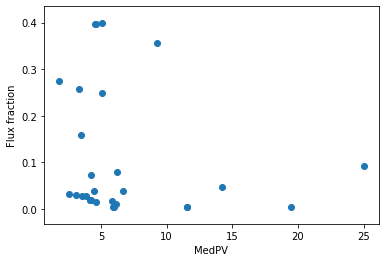

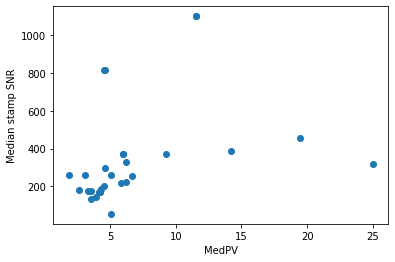

Max SNR: 1099.2532519772087


In [6]:
print(PyTorch_data.shape, pyDANDIA_data.shape)

print('PyTorch')
metrics(PyTorch_data, stamp_info=False, plot=False)
print('\npyDANDIA')
metrics(pyDANDIA_data, stamp_info=False, plot=False)

In [7]:
import pandas as pd
import seaborn as sns

In [8]:
def numpy_to_DataFrame(array):
    
    # out = np.vstack((MFBs, MFVs, Ps_normalised, np.array(norm_phot_resids).flatten(),
    #                 image_SNRs, image_FWHMs, stamp_ids)).T
    
    df = pd.DataFrame(array, columns=['MFB', 'MFV', '$P$',
                                      '$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$',
                                      '$\mathrm{SNR}_{I}$',
                                      '$\mathrm{FWHM}_{I}$',
                                      'Stamp ID'])


    
    # categories
    # SNR: 3 categories
    # 8 < $\mathrm{SNR}_{I}$ < 40, 40 < $\mathrm{SNR}_{I}$ < 200, 200 < $\mathrm{SNR}_{I}$ < 1000
    cat1, cat2, cat3 = '8 < $\mathrm{SNR}_{I}$ < 40', '40 < $\mathrm{SNR}_{I}$ < 200', '200 < $\mathrm{SNR}_{I}$ < 1100'

    df['SNR category'] = 0
    df['SNR category'][(8. < df['$\mathrm{SNR}_{I}$']) & (df['$\mathrm{SNR}_{I}$'] < 40.)] = cat1
    df['SNR category'][(40. < df['$\mathrm{SNR}_{I}$']) & (df['$\mathrm{SNR}_{I}$'] < 200.)] = cat2
    df['SNR category'][(200. < df['$\mathrm{SNR}_{I}$'])] = cat3

    df = df[df['SNR category']!= 0]
    
    # remove variable source (stamp 1)
    #df = df[df['Stamp ID'] != 1.0]

    # set to categorical type
    df['SNR category'] = df['SNR category'].astype('category')
    
    ## drop unecessary columns
    df = pd.DataFrame.drop(df, columns=['$\mathrm{FWHM}_{I}$', '$\mathrm{SNR}_{I}$', 'Stamp ID'])
    
    # rearrange columns in correct order
    cols = df.columns.to_list()
    cols = [cols[2], cols[0], cols[1], cols[3], cols[4]]     
    df = df[cols]
    
    ## metrics by SNR category
    cats = [cat1, cat2, cat3]
    
    output_metrics = np.array([])
    
    for cat in cats:
        print('\n')
        print(cat)
        print('$P$:', np.median(df['$P$'][df['SNR category'] == cat]))
        N_set = len(df['$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'][df['SNR category'] == cat])
        print('MFB:', np.median(df['MFB'][df['SNR category'] == cat]))
        print('MFV:', np.median(df['MFV'][df['SNR category'] == cat]))
        nr = df['$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'][df['SNR category'] == cat]
        # remove bad outliers
        sigma = mad_std(nr)
        nr = nr[nr < np.nanmedian(nr) + 5*sigma]
        nr = nr[nr > np.nanmedian(nr) - 5*sigma]
        MPB = np.mean(nr)
        MPV = np.std(nr, ddof=1)**2
        print('N_set:', N_set)
        print('MPB:', MPB)
        print('MPV:', MPV)
        print('MedPB:', np.median(df['$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'][df['SNR category'] == cat]))
        sigmad = mad_std(df['$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'][df['SNR category'] == cat])
        print('MedPV:', sigmad**2)
        
        output_metrics = np.append(output_metrics, [np.median(df['$P$'][df['SNR category'] == cat]),
                                                   np.median(df['MFB'][df['SNR category'] == cat]),
                                                   np.median(df['MFV'][df['SNR category'] == cat]),
                                                   MPB, MPV])
        
    return df, output_metrics

print('pyDANDIA')
pyDANDIA_df, pyDANDIA_metrics = numpy_to_DataFrame(pyDANDIA_data)
print('\nPyTorch')
PyTorch_df, PyTorch_metrics = numpy_to_DataFrame(PyTorch_data)

pyDANDIA


8 < $\mathrm{SNR}_{I}$ < 40
$P$: 1.0286165107104963
MFB: -0.00026747656274317264
MFV: 1.1562943698446728
N_set: 43
MPB: 3.617523367668307
MPV: 5.631638798346242
MedPB: 3.6364903450012207
MedPV: 8.271015505446671


40 < $\mathrm{SNR}_{I}$ < 200
$P$: 1.0116161835959634
MFB: 0.0007153386881404222
MFV: 1.2424806943217508
N_set: 2333
MPB: -1.150978860754098
MPV: 9.437803739824021
MedPB: -1.1945699453353882
MedPV: 9.230459387213255


200 < $\mathrm{SNR}_{I}$ < 1100
$P$: 0.9987505582350242
MFB: 0.0015480602002975372
MFV: 1.3870987649157327
N_set: 5038
MPB: -1.4931168383721325
MPV: 22.893967163900058
MedPB: -0.8707420825958252
MedPV: 13.959014641367583

PyTorch


8 < $\mathrm{SNR}_{I}$ < 40
$P$: 0.9184370829894961
MFB: 0.124936654965574
MFV: 1.1919478108933201
N_set: 43
MPB: 3.444758878197781
MPV: 4.9931607652509955
MedPB: 3.361325263977051
MedPV: 5.150159079577247


40 < $\mathrm{SNR}_{I}$ < 200
$P$: 1.0119031822152058
MFB: 0.048721417302161646
MFV: 1.2654329518442942
N_set: 2333
M

/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


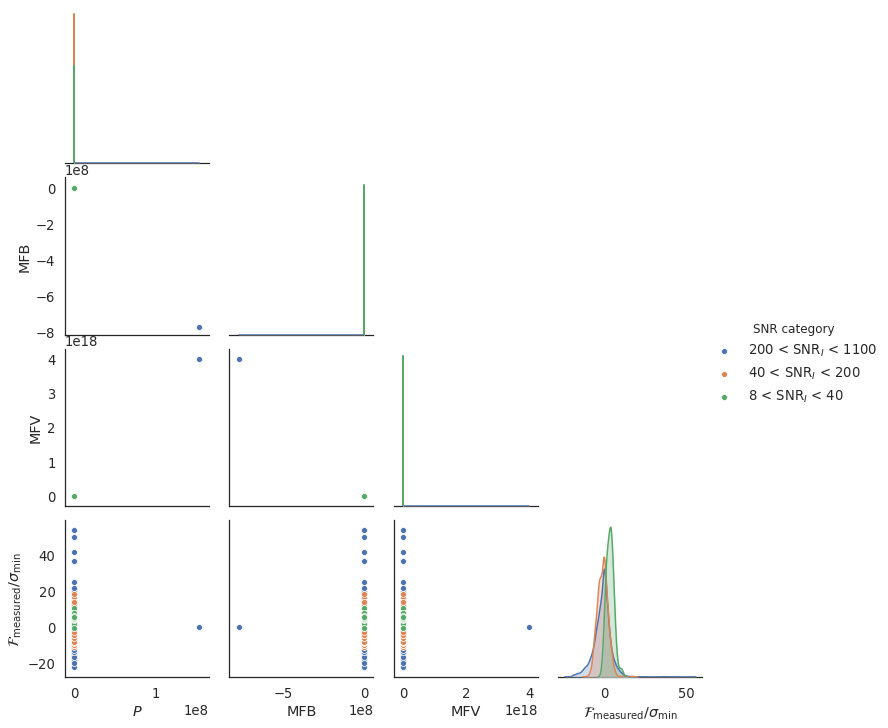

In [9]:
sns.set(context='notebook', font_scale = 1.2, style='white')
sns.pairplot(PyTorch_df, hue='SNR category', corner=True)
#plt.savefig('Corner_plot_PyTorch_real_data_.png')
#plt.show()

#sns.set(context='notebook', font_scale = 1.2, style='white')
#sns.pairplot(pyDANDIA_df, hue='SNR category', corner=True)
#plt.show()

In [10]:
# for clarity when plotting, exclude bad outliers
def clip(df):
    
    labels = ['$P$', 'MFB', 'MFV', '$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$']
    
    for label in labels:
        column = df[label]
        std = mad_std(column)
        sigma = 5
        column[column > np.median(column) + sigma*std] = 0
        column[column < np.median(column) - sigma*std] = 0
        
        #if label == '$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$':
        #    print('MPB:', np.mean(column))
        #    print('MPV:', (np.std(column))**2)
          
    clipped_df = df[df != 0]
    
    return clipped_df
        
PyTorch_df_clipped = clip(PyTorch_df)

/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


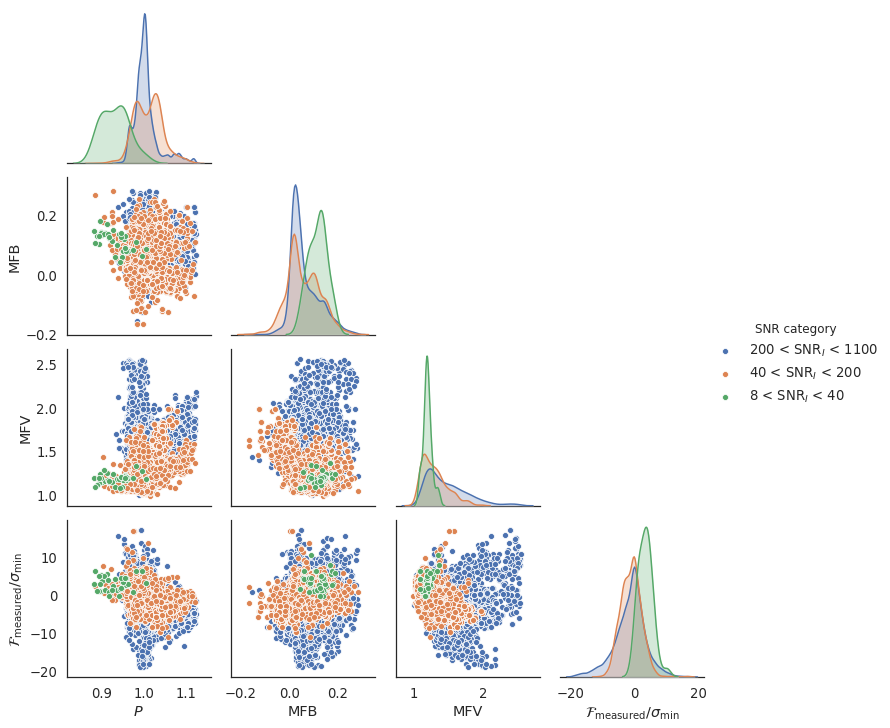

In [11]:
### cut outliers from plots for clarity
sns.set(context='notebook', font_scale = 1.2, style='white')
pp = sns.pairplot(PyTorch_df_clipped, hue='SNR category', corner=True)
#pp.axes[1,0].set_ylim(-0.2,0.2)
#pp.axes[3,1].set_xlim(-0.2,0.2)
#pp.axes[2,0].set_ylim(0.8, 3.5)
#pp.axes[3,2].set_xlim(0.8, 3.5)
#pp.axes[3,0].set_xlim(0.8, 1.35)
#pp.axes[3,1].tick_params(labelsize=10)
#pp.axes[4,2].tick_params(labelsize=12)
plt.savefig('Corner_plot_PyTorch_real_data_.png', bbox_inches='tight')

In [12]:
#### difference column for paper ####
diff = np.abs(pyDANDIA_metrics - PyTorch_metrics)
for d in diff:
    print(d)

0.1101794277210002
0.12520413152831716
0.035653441048647316
0.17276448947052625
0.6384780330952466
0.0002869986192424179
0.04800607861402122
0.022952257522543373
0.0412157777290183
0.2655227534344693
0.0025281628076174734
0.04140562508728082
0.014657097836949795
0.22674334622042513
0.27009600145516544
